In [ ]:
# Import functions to setup gridworld problem data from gridworld_generators.py
from gridworld_generators import gen_next_pos, prob_func_generator, reward_func_generator
from value_iteration import value_iteration

# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
grid_rows = 5
grid_cols = 5
Sg = {(i,j) for i in range(grid_rows) for j in range(grid_cols)}
Ag = {"UP", "DOWN", "LEFT", "RIGHT"}
reward_states = {(2,2):-10, (3,3): 10}              # Define reward states
Rg = reward_func_generator(reward_states, -1, Sg)
Pg = prob_func_generator(0.7, Sg, Ag)
gamma = 0.9
result = value_iteration(Sg, Ag, Pg, Rg, gamma, max_iterations=100)

Optimal Value Function:
[20.7215, 26.1896, 30.5507, 34.6394, 29.4104]
[26.1896, 30.2301, 35.4389, 41.4688, 37.5332]
[30.5507, 35.4389, 42.7033, 50.4504, 44.0891]
[34.6394, 41.4688, 50.4504, 45.8839, 51.1151]
[29.4104, 37.5332, 44.0891, 51.1151, 40.4427]

Optimal Policy:
['RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'DOWN']
['DOWN', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN']
['RIGHT', 'DOWN', 'RIGHT', 'DOWN', 'DOWN']
['RIGHT', 'RIGHT', 'RIGHT', 'RIGHT', 'LEFT']
['RIGHT', 'RIGHT', 'RIGHT', 'UP', 'LEFT']


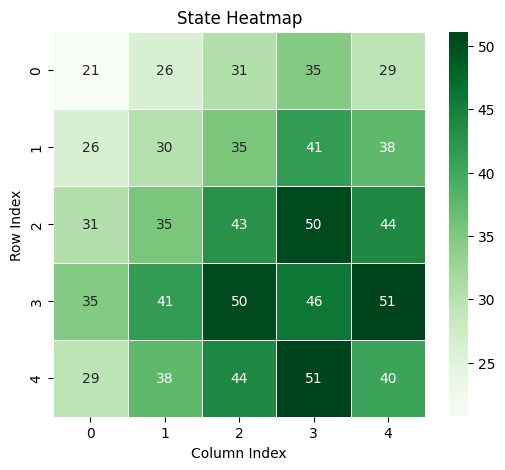

In [14]:
print("Optimal Value Function:")
for i in range(grid_rows):
    print([round(result["value_function"][(i, j)], 4) for j in range(grid_cols)])

print("\nOptimal Policy:")
for i in range(grid_rows):
    print([result["optimal_policy"][(i, j)] for j in range(grid_cols)])
    


# Example dictionary: {(row, col): value}
state_values = result["value_function"]

# Extract grid size
rows = max(key[0] for key in state_values) + 1
cols = max(key[1] for key in state_values) + 1

# Create a 2D numpy array filled with NaNs (for missing values)
heatmap_data = np.full((rows, cols), np.nan)

# Fill array with values from the dictionary
for (r, c), value in state_values.items():
    heatmap_data[r, c] = value

# Set a custom colormap to match the green theme
cmap = sns.color_palette("Greens", as_cmap=True)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, cmap="Greens", linewidths=0.5)

# Labels and title
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.title("State Heatmap")

plt.show()